# P1: Modelado de un vehículo

P2: Segimiento de Caminos

P3: SLAM basado en EFK

P4: Evitar Obstáculos

P5: Planificación de Caminos - Dijkstra

P6: Planificación de Caminos - A*

P7: Navegación Autónoma


<div style="color: red;">

Dudas
    
A. GPS diferencial
    
1. ¿el "plano del receptor" se refiere al sistema de coordenadas del receptor?
2. de dónde salen los valores de la matriz
    
</div>

\newpage


# Segimiento de Caminos

Se desea simular el movimiento de un vehículo con tracción diferencial, de la práctica anterior, con los siguientes parámetros: 
- distancia entre ruedas 0.8 m,
- radio de las ruedas 0.1 m,
- velocidad máxima de las ruedas 15 rad/s.

Para ello se tendrán que implantar las ecuaciones de movimiento, así como el modelo dinámico simplificado de los dos actuadores. Se considerará una constante de tiempo de 0.12 s, ganancia unidad

\newpage

## Ejercicio

Simular la navegación punto a punto del robot móvil a una velocidad de 1.2 m/s. 

- Dos puntos objetivos consecutivos sobre una superficie plana sin obstáculos deben estar separados al menos 20 m. 
- Para conocer su posición el vehículo lleva a bordo un GPS diferencial que proporciona datos cada 0.3s
- Un ejemplo de camino vendría dado por los siguientes puntos objetivo: 

Coordenada x (m) | Coordenada y (m)
-----------------|-----------------
0 | 0
20 | 0 
20 | 20
-10 | 30
-20 | 10
0 | -30
0 | 0


El punto objetivo cambiará cuando el vehículo se encuentre a menos de 1m de distancia del anterior. Utilizar distintos valores de la ganancia del controlador proporcional y mostrar gráficamente el camino recorrido, así como la evolución temporal de la velocidad del vehículo en su recorrido para cada una de las ganancias consideradas. Coordenadas expresadas en m de los puntos objetivo que conforman el camino a seguir por el vehículo. 

### Modelo Simulink

Para esta práctica reutilizaremos el modelo de los motores, el modelo cinemático directo y el modelo de odometría que diseñamos en la práctica anterior, y añadiremos:

- El GPS diferencial
- Un subsistema de seguimiento de caminos explícitos
- Y un modelo cinemático inverso, que en esta práctica sí se necesita.

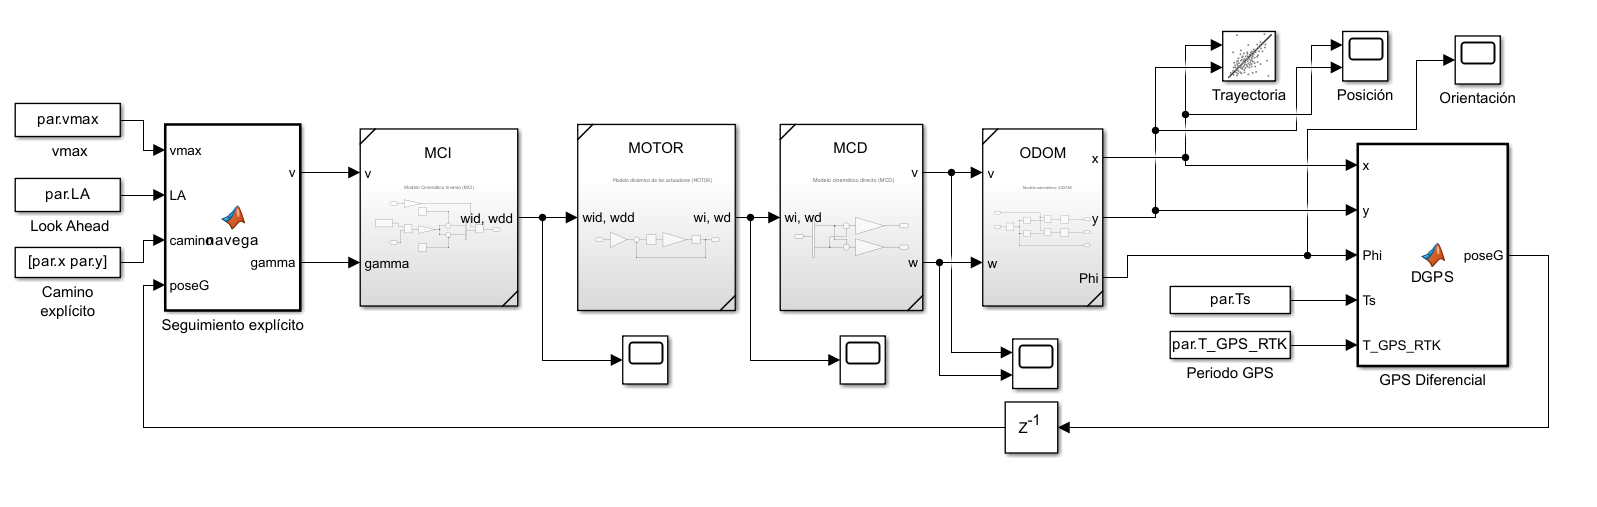


\newpage

#### GPS diferencial

Partimos del código que simula un receptor GPS diferencial. Para realizar la simulación, el código añade ruido aleatorio a la pose que recibe como entrada. Internamente invoca la función sqrtm(A) que calcula X tal que X*X = A (probablemente A es una matriz de covarianza) y le añade ruido utilizando la función randn

De cara a utilizar la función, conectaremos la salida de la odometría a la entrada del GPS diferencial. Adicionalmente, cambiamos el código para que la posición sólo se actualice cada T_GPS_RTK segundos:

**DGPS.m**

```C
function poseG = DGPS(x, y, Phi, Ts, T_GPS_RTK)
    %//DGPS Simulacion de un receptor GPS diferencial 
    %// PoseO: posicion real en el plano del receptor según la odometría
    %// poseG: coordenadas X, Y, Phi medidas por el GPS

    %// El GPS proporciona datos cada 0.3s / 0.025 = cada 12 iteraciones
    persistent i_Gps_Rtk;
    persistent N_Gps_Rtk;
    persistent ultPose;
    
    %// Inicializar el tiempo de simulación y el tiempo de última lectura
    if isempty(i_Gps_Rtk)
        ultPose = [0 0 0]';
        N_Gps_Rtk = Ts / T_GPS_RTK;
        i_Gps_Rtk = 0;
    end

    %// Actualizar valores sólo si pasaron 0.3 s desde última lectura
    if (mod(i_Gps_Rtk, N_Gps_Rtk) == 0)
        ruido = sqrtm([0.4 -0.014 0; -0.014 0.5 0;0 0 0.1])*randn(3, 1);        
        ultPose = real([x+ruido(1); y+ruido(2); Phi+ruido(3)]);
    end
    i_Gps_Rtk = i_Gps_Rtk + 1;
    poseG = ultPose;
end

```

\newpage

#### Subsistema de seguimiento de caminos

Se trata de resolver un problema de seguimiento de caminos explícitos. El robot empieza cada transición cuando se encuentra a menos de una distancia LA (Look Ahead) del objetivo. En las transiciones de un punto objetivo al siguiente, el robot tiene que describir un arco de circunferencia entre su posición actual y el siguiente punto objetivo, siendo la orientación del robot tangente al arco.

- Tanto la odometría como el GPS diferencial nos permiten conocer la pose del robot respecto al sistema global: $P_0=(x_0, y_0, \Phi_0)$

- Para el seguimiento de caminos, sabemos la posición del siguiente objetivo del camino respecto al sistema global $P_n=(x_n, y_n)$ 

- La distancia entre la posición actual y el siguiente objetivo será independiente del sistema de coordenadas:

$$\Delta x = x_n - x_0, \quad \Delta y = y_n - y_0, \quad d^2 = \Delta x^2 + \Delta y^2 \tag {2.1}$$

- Pero para calcular la curvatura, tenemos que obtener la posición del siguente objetivo en el sistema de coordenadas del robot $(\hat x_n, \hat y_n)$ utilizando las ecuaciones del T1 pág55:

$$
\left\{
\begin{aligned}
  x_n = x_0 + \cos (\Phi_0) \hat x_n - \sin (\Phi_0) \hat y_n \\
  y_n = y_0 + \sin (\Phi_0) \hat x_n + \cos (\Phi_0) \hat y_n
\end{aligned}
\right.
\quad \implies \quad
\left\{
\begin{aligned}
  \hat x_n = \cos (\Phi_0) (x_n - x_0) + \sin (\Phi_0) (y - y0) \\
  \hat y_n = -\sin (\Phi_0) (x_n - x_0) + \cos (\Phi_0) (y_n - y_0)
\end{aligned}
\right. \tag {2.2}
$$


- Una vez tenemos el objetivo en el sistema de coordenadas del robot, la curvatura se obtiene como:

$$\gamma_d = \frac {2 \hat y_n} {d^2} \tag {2.3}$$


\newpage

El código de la función de navegación queda como sigue: 

```c
function [v, gamma]= navega(vmax, LA, camino, poseG)    

    %// Comprobar si llegamos al final del camino y parar el robot
    persistent paso;
    if isempty(paso)
        paso = 1;
    end

    %// Inicializamos los valores de v y gamma
    v = vmax;
    gamma = 0;

    %// Si llegamos al final del camino, dentener el robot
    if paso > length(camino)        
        v = 0;
    else        
        %// Cálculo de distancia hasta siguiente punto del camino
        deltaX = camino(paso, 1) - poseG(1);
        deltaY = camino(paso, 2) - poseG(2);
        dist2 = deltaX^2 + deltaY^2;
        dist = sqrt(dist2);

        %// Si estamos cerca del objetivo, siguiente objetivo
        if (dist < LA)
            paso = paso + 1;
        end

        %// corregir el ángulo a menos que se este muy cerca del objetivo
        if (dist > LA/10) 

            %// Posición del siguiente objetivo en el sistema del robot
            Phi = poseG(3); % orientación del robot
            TRot = [cos(Phi), sin(Phi);-sin(Phi), cos(Phi)];
            Xn_hat = TRot * [deltaX; deltaY];

            %// Consigna de velocidad y curvatura
            gamma = 2 * Xn_hat(2) / dist2;
        end
    end
```

\newpage

#### Modelo cinemático inverso

Como necesitamos comandar las velocidades angulares de las ruedas a partir de la posición del siguiente punto en el camino, necesitamos el modelo cinemático inverso del direccionamiento diferencial (ver T1 pág 46), que nos proporciona la consigna de velocidades angulares que se debe comandar a cada rueda



$$w_{id} = \frac v R (1 - K \cdot \gamma), \quad w_{dd} = \frac v R (1 + K \cdot \gamma) \tag {2.3}$$

Siendo $v$ la velocidad lineal, $K$ la semidistancia entre ruedas, $R$ el radio de las ruedas y $\gamma$ la curvatura calculada por el seguimiento de caminos, a la que se aplica una ganancia par.Kgamma:

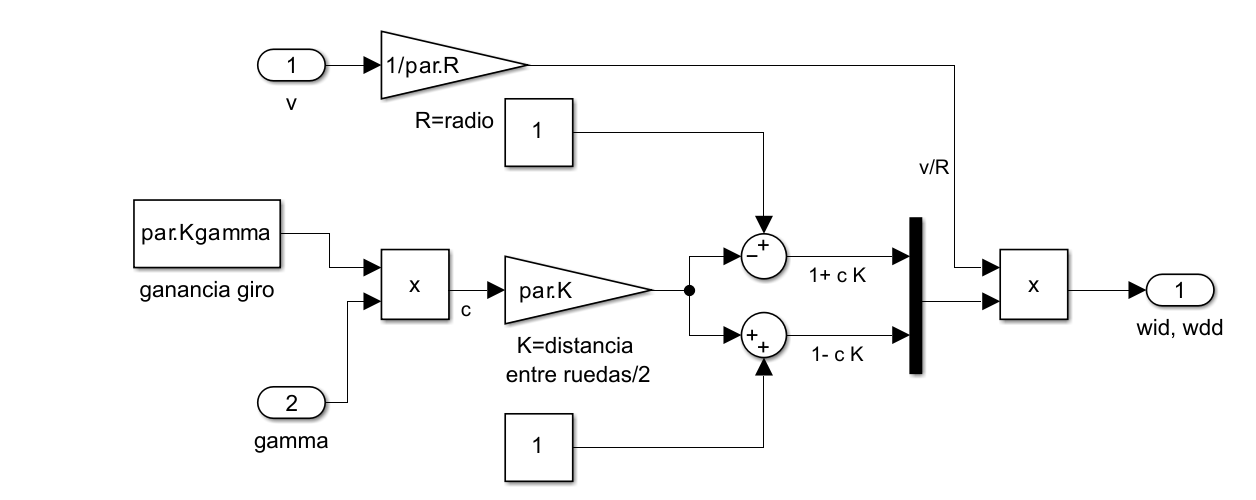


#### Parametrización

**P21param.m**
```
clear;
par.kw = [1, 1]; % Ganancia de los motores izquierdo y derecho
par.tau = 0.12; % Constante de tiempo de los motores (segundos)
par.R = 0.1; % Radio de las ruedas (metros)
par.Ts = 0.025; % Tiempo de muestreo (segundos)
par.K = 0.4; % distancia entre ruedas 2K=0.8 => K=0.4
par.T_GPS_RTK = 0.3; % Periodo de medición del GPS diferencial (segundos)
par.x = [0, 20, 20, -10, -20, 0, 0]'; % puntos del controno en el eje X
par.y = [0, 0, 20, 30, -10, -30, 0]'; % puntos del contorno en el eje y
par.LA = 1; % look ahead - distancia a partir de la que cambia el objetivo (metros)
par.vmax = 1.2; % Velocidad lineal del motor (metros/segundo)
par.wmax = [-15, 15]; % Velocidad máxima de las ruedas
par.Kgamma = 2; % Ganancia del giro
par.Pose0 = [0; 0; 0]; % Posición inical del robot
addpath('Subsistemas'); % añade la carpeta de subsistemas al path
```

\newpage

### Pruebas

**Ganancia = 1**

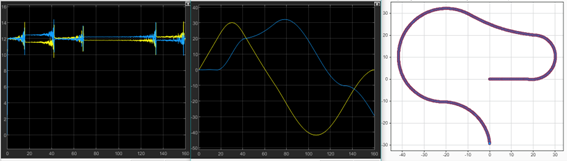

**Ganancia = 0.5**

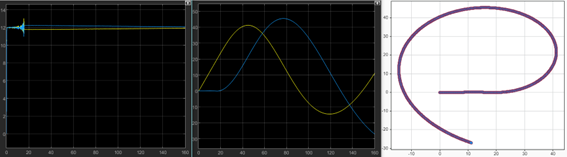

**Ganancia = 2**

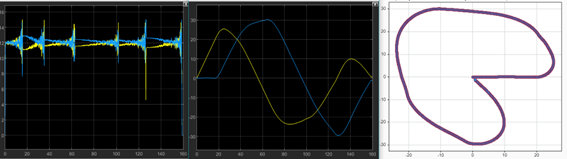

**Ganancia = 4**

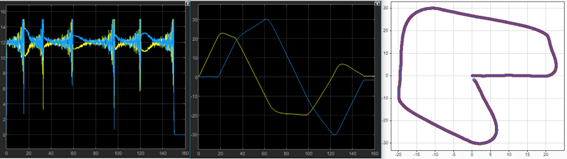


\newpage

## Ejercicio

Empleando el método de Persecución Pura se pretende que el robot móvil recorra un pasillo largo a una velocidad de 0.3 m/s. Para ello, se utilizarán las medidas de un telémetro láser que barre 360º, obtenidas cada 0.5 segundos y situado sobre el origen de coordenadas local al vehículo. Se va a considerar que el objetivo se encuentra delante del vehículo a una distancia en el eje y de 1 m. Realizar la simulación partiendo de distintas posiciones iniciales

Coordenadas expresadas en m de los puntos que conforman el pasillo a seguir por el vehículo: 

Coordenada x (m) | Coordenada y (m)
-----------------|-----------------
0 | 0
30 | 0 
30 | 10
0 | 10
0 |0 

**NOTA**: En caso de que para conseguir el giro del vehículo con la velocidad impuesta en el enunciado sea necesario superar la velocidad máxima de las ruedas, se dará prioridad a la orientación a costa de reducir la velocidad lineal deseada del vehículo. 

### Modelado

Se trata de resolver un problema de seguimiento de caminos implícitos. En este caso, el camino está condicionado por la existencia de un pasillo que tiene una anchura de 10 m y una longitud de 30 m.

Para realizar el modelo, reutilizamos los mismos subsistemas del apartado anterior eliminando el GPS y sustituyendo el seguimiento de caminos explícito por un seguimiento implícito:


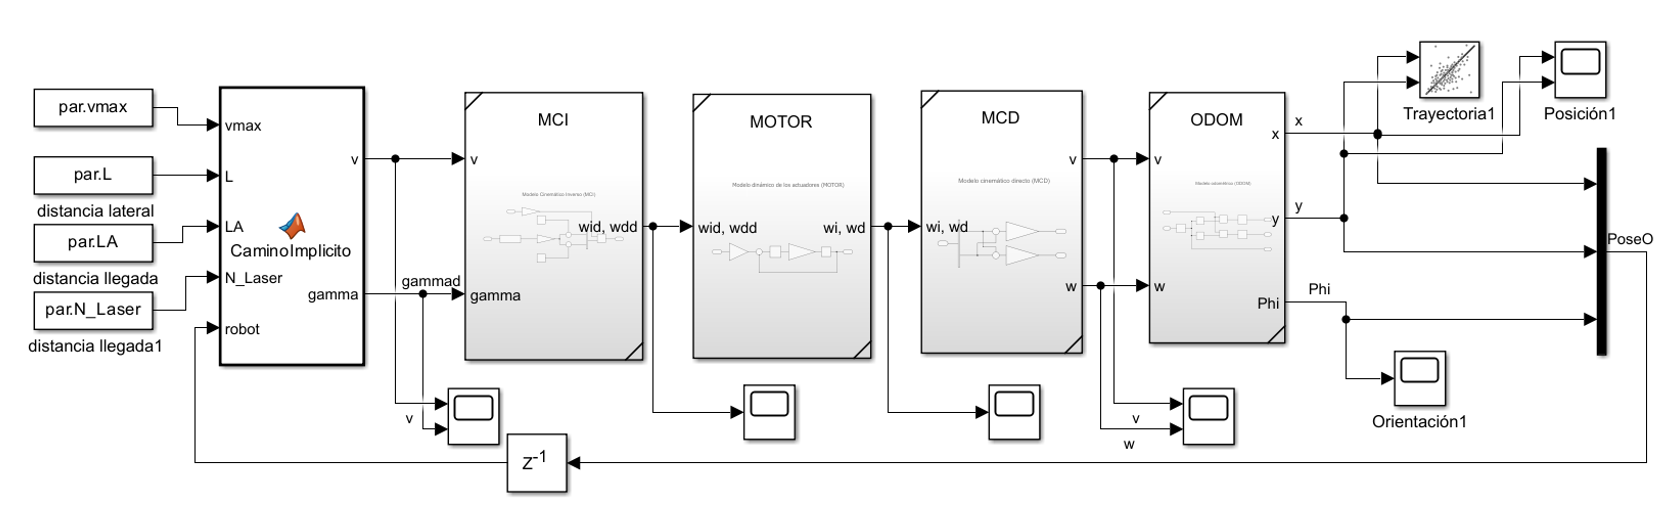

\newpage

#### Seguimiento de camino imlícito

Dado que el objetivo se encuentra al final del pasillo a una distancia de 1 m de la parede derecha, estaríamos en el caso de seguimiento de una pared (ver página 58 del T1):

Partiendo de los datos del enunciado:
- $L = 1$: distancia del objetivo a la pared izquierda (metros)
- $l = 0$: el sensor se encuentra en el origen de coordenadas local del vehículo

Para ajustar la orientación del robot, partimos de la información que nos proporciona el láser 2D:

- $D_d$: mínimo de distancia a la pared por la derecha del robot
- $\Delta \Phi$: ángulo que minimiza la distancia por la derecha
- $d_L = L - D_d$: distancia que el robot se tiene que desplazar a la izquierda para seguir la pared
- $d$: distancia a la parede del fondo, obtenida como el máximo de la distancia entre entre -90 y +90 º al frente del robot
- $D = d + l = d$: distancia desde el origen de coordenadas del robot a la pared del fondo (coincide con la distancia desde el sensor)


Las ecuaciones a implementar serían:

$$\delta x = d_L \sin \Delta \Phi + d \cos \Delta \Phi \tag {2.4a}$$
$$\delta y = d_L \cos \Delta \Phi - d \sin \Delta \Phi \tag {2.4b}$$
$$\gamma_d = \frac {2 \delta_y} {D^2} \tag {2.5}$$

#### Implementación de la función de seguimiento

El código de la función CaminoImplicito de Simulink se limita a invocar a la función SeguirPasilloDerecho en Matlab:

```C
function [v, gamma] = CaminoImplicito(vmax, L, LA, N_Laser, robot)
   [v, gamma] = SeguirPasilloDerecho(vmax, L, LA, N_Laser, robot);
end
```

La función SeguirPasilloDerecho implementa las ecuaciones a partir de las distancias obtenidas con el láser

```C
    % Calcular el ángulo que minimiza la distancia
    iFrente = 37; % angulos(37) = 0º
    iDetras = 73; % angulos(73) = 360º
    [minD, MinI] = min(dist(iFrente: iDetras));
    iPhi = iFrente-1+MinI;
    DeltaPhi = -(pi/2 + angulos(iPhi));

    % Asignar una distancia mínima cuando al frente no se ven obstáculos
    d = min(ancho, dist(iFrente));

    % Calcular el desplazamiento y la curvatura en coordenadas del robot
    dL = L - minD; 
    dx = dL*sin(DeltaPhi)+d*cos(DeltaPhi);
    dy = dL*cos(DeltaPhi)-d*sin(DeltaPhi);
    D = sqrt(dx^2+dy^2);
    gammad = 2*dy/D^2;

```

#### Implementación del Láser 2D

Para implementar el láser se ha optado por utilizar la función rayIntersection. Para ello, previamente hay que disponer de un mapa, y para evitar que el mapa se tenga que calcular en cada iteración se guarda en una variable persistente que se inicializa la primera vez:

```C
    persistent mapa;
    persistent largo;
    persistent ancho;
    persistent angulos;
    persistent iteracion;
    persistent vprev;
    persistent gammadprev;
    
    % Inicializar las variables en la primera iteración
    if isempty(angulos)
        ancho=100; % dm
        largo=300; % dm
        angulos=pi:-(5*pi/180):-pi;
        pasillo = zeros(ancho, largo);        
        for i=1:largo
            pasillo(1, i)=1;
            pasillo(ancho, i)=1;
        end
        for i = 1:ancho
            pasillo(i, 1) = 1;
            pasillo(i, largo) = 1;
        end
        mapa=binaryOccupancyMap(pasillo);
        iteracion = -1;
        gammadprev = 0;
        vprev = -1;
    end
```

Para simular el tiempo de refresco de 0.5 segundos del láser, en las iteraciones en las que aún no ha pasado medio segundo desde la última actualiación se devuele el último cáculo. Además, si el robot ha llegado a su destino también se devuelve el control sin actualizar la velocidad ni la curvatura.

```C
    % Salir del bucle si no se han llegado a 20 iteraciones o ya en destino
    iteracion = iteracion + 1;
    gammad = gammadprev;
    v = vprev;

    if (mod(iteracion, N_Laser) ~= 0) || (vprev == 0))
        return;
    end
```

\newpage

Para el cálculo de la distancia a los obstáculos, se limita el alcance del láser al ancho del pasillo y se añade ruido aleatorio (la línea comentada funciona en Matlab pero falla en Simulink)

```C
    % Calcular la distancia a los obstáculos alrededor
    obst = rayIntersection(mapa, robot, angulos, ancho); % obstáculos
    delta = [obst(:,1)-robot(1), obst(:,2)-robot(2)]; % vector diferencia
    dist = (delta(:,1).^2 + delta(:,2).^2).^0.5; % obtener la distancia
    %dist = max(0, dist+0.5*randn); % no funciona en Simulink
    dist = dist+0.5*randn; % añadir ruido uniforme con media de 5mm
```

Al final de la función: 

1. Se comprueba si se ha llegado al final del pasilo para detener el robot
2. Se ajusta la velocidad lineal del robot para reducirla en los casos que la curvatura sea más o menos grande.
3. Se guardan los valores actualizados de velocidad y curvatura para devolverlos en las siguientes iteraciones hasta la próxima actualización

```C
    % Detener el robot si hemos llegado al destino    
    if D < LA
        v = 0;
        gammad = 0;

    % La velocidad máxima se reduce cuando hay mucha curvatura
    elseif gammad > 0.1  
        v = 0.1 * vmax; % 10% de la velocidad máxima
    elseif gammad > 0.05
        v = 0.5 * vmax; % 5% de la velocidad máxima
    else
        v = vmax; % velocidad máxima
    end

    % Guardar el resultado para siguientes iteraciones
    gammadprev = gammad;
    vprev = v;
```

\newpage

#### Parametriazción

Para la parametrización de la simulación hay que tener en cuenta que el mapa está en decímetros, por lo que todas las distancias y velocidades se tienen que expresar en esta unidad:

**P22param.m**

```
clear;
par.K = 4; % distancia entre ruedas 2K=0.8 => K=4 decímetros
par.R = 1; % Radio de las ruedas (decímetros)
par.wmax = [-15, 15]; % Velocidad máxima de las ruedas
par.kw = [1, 1]; % Ganancia de los motores izquierdo y derecho
par.tau = 0.12; % Constante de tiempo de los motores (segundos)

par.vmax = 3; % Velocidad lineal del motor (decímetros/segundo)
par.T_Laser = 0.5; % Periodo de medición del láser (segundos)
par.N_Laser=par.T_Laser/par.Ts; % refrescar cada 20 iteraciones

par.Ts = 0.025; % Tiempo de muestreo (segundos)
%par.x = [0, 30, 30, 0, 0]'; % puntos del controno en el eje X
%par.y = [0, 0, 10, 10, 0]'; % puntos del contorno en el eje y
par.L = 10; % distancia a la pared de la derecha (decímetros)
par.LA = 10; % distancia a partir de la que no se acerca más al fondo
par.Kgamma = 4; % Ganancia del giro
par.Pose0 = [50; 30; 0]; % Posición inical del robot

addpath('..\Subsistemas'); % añade la carpeta de subsistemas al path
addpath('..\P2\simulaLaser2D'); % añade la carpeta del láser al path
```


\newpage

### Resultados

A continuación se muestran los resultados de las pruebas realizadas:

- Empezar desde distintos puntos de origen
- Empezar con una orientación inicial distinta de 0º
- Empezar a la derecha del pasillo y dirigirse a la izquierda

En cada prueba se indica la pose inicial (decímetros para X e Y y radianes para Phi) y la ubicación en los puntos cardinales del mapa.

#### par.Pose0 = [10; 85; 0]; % Desde NW a SE

El robot detecta que la parede más cercana a su derecha es la del lado izquierdo, así que la sigue hasta que gira en la esquina y se dirige al fondo del pasillo. En el giro la curvatura se hace muy grande y la velocidad lineal se reduce. En algo más de 100 segundos llega al destino y se para

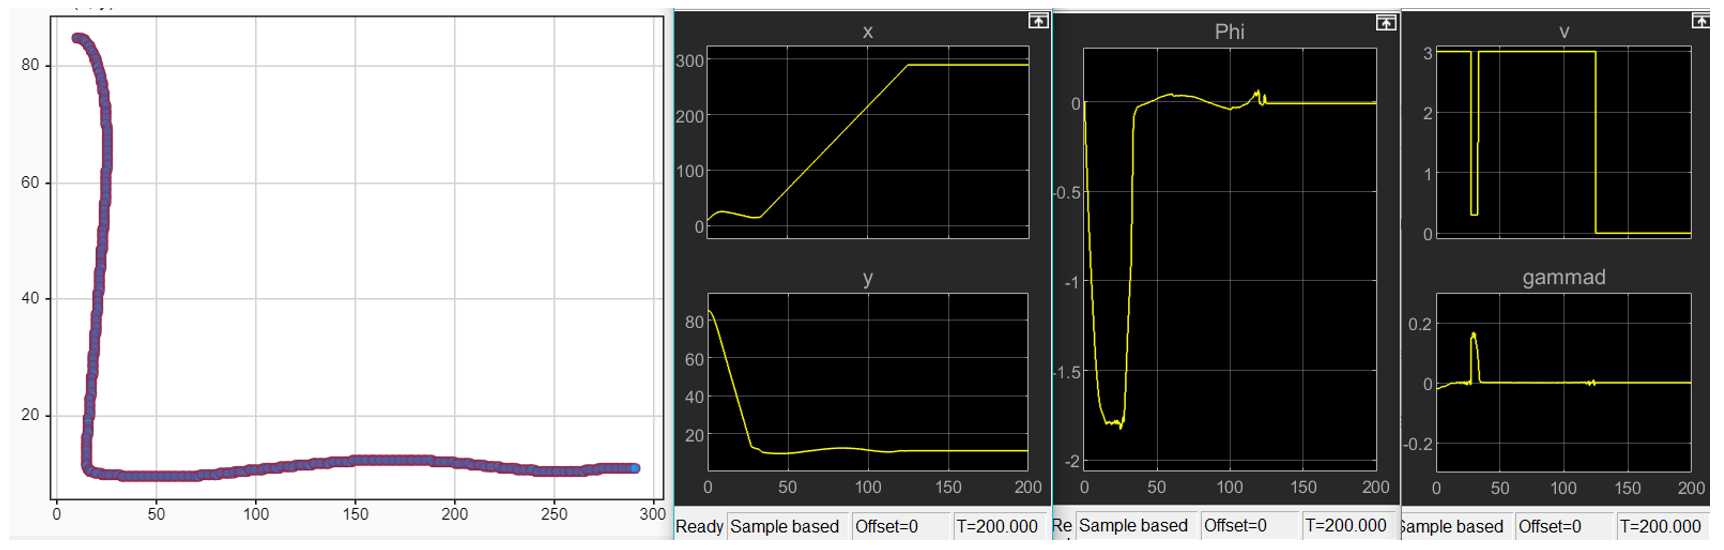

#### par.Pose0 = [10; 15; 0]; % Desde SW a SE

El robot ajusta la distancia a la pared para reducirla de 15 (1.5 m) a 10 (1m). En menos de 100 segundos llega al destino y se para.

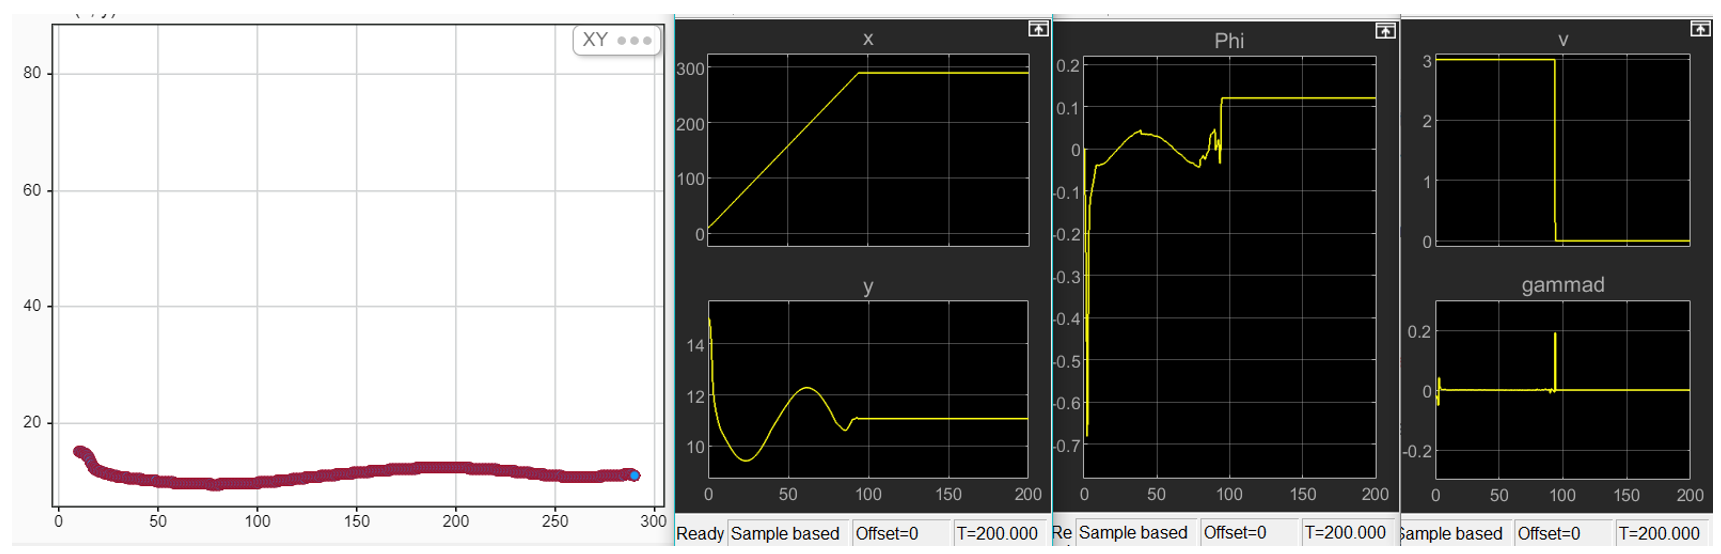

\newpage

#### par.Pose0 = [10; 50; 0]; % W a E

El robot se comporta de forma análoga al caso NW a SW, pero la distancia a recorrer hasta la base del pasillo es menor

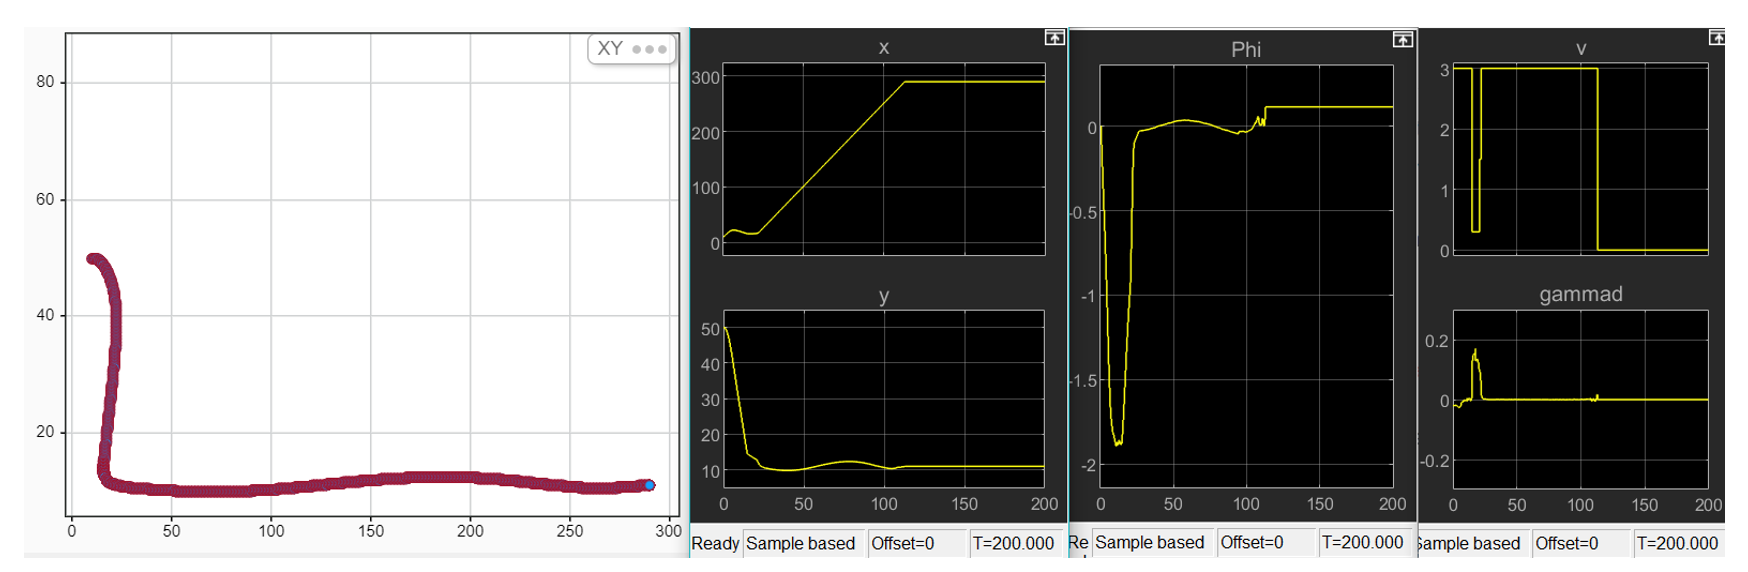

#### par.Pose0 = [10; 50; pi/4]; % W a E orientado a NW

El robot empieza apuntando hacia arriba a la derecha, así que necesita mayor curvatura para corregir si orientación

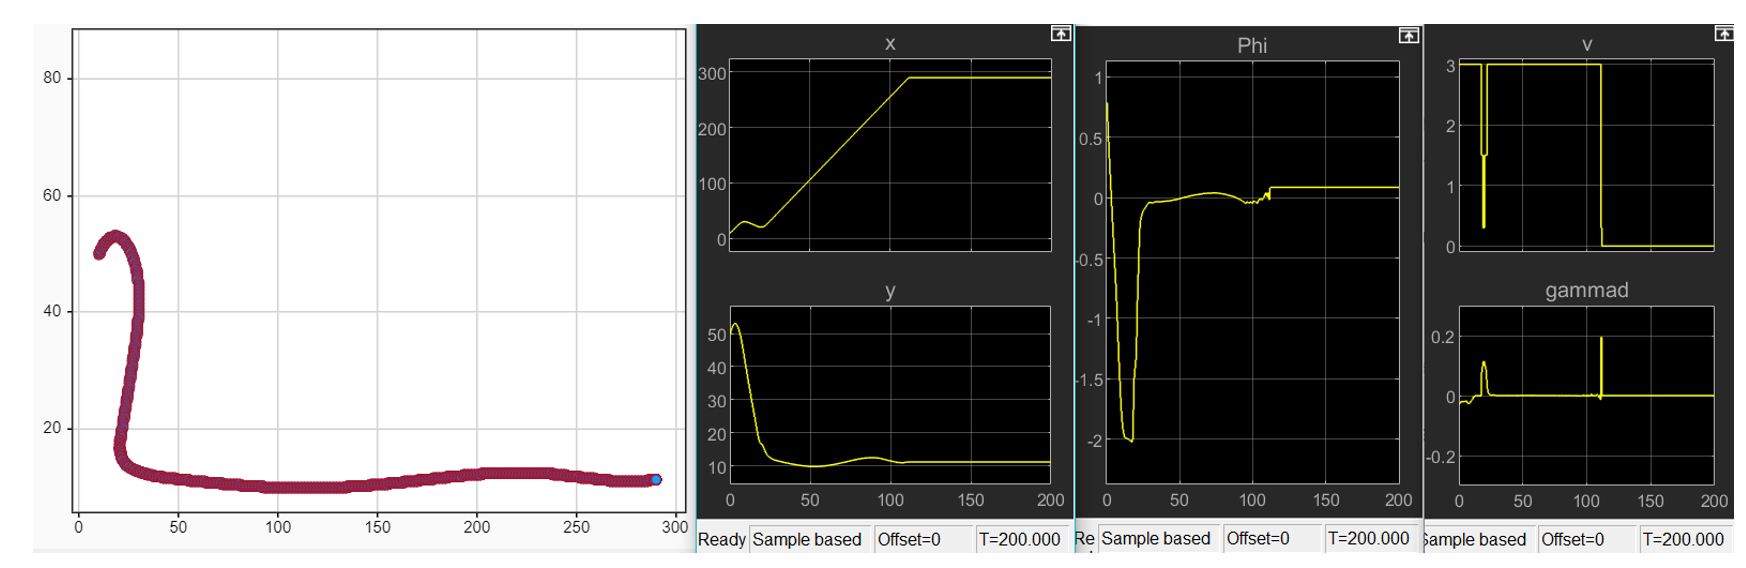

#### par.Pose0 = [10; 50; -pi/4]; % W a E orientado a SW

El robot está apuntando hacia abajo a la derecha. Cuando llega a la base del pasillo interpreta que ya ha llegado al destino y se para

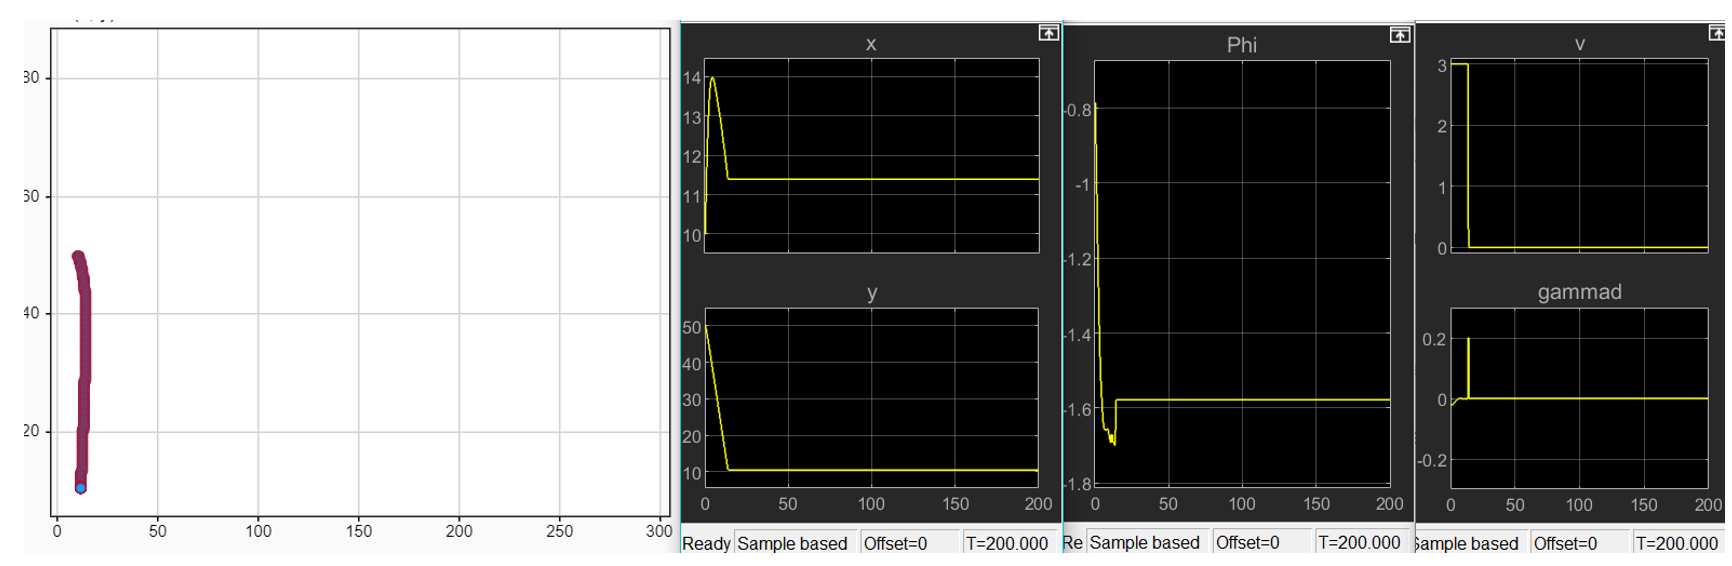

\newpage

#### par.Pose0 = [20; 50; -pi/4]; % W a E orientado a SW separado inicio

El robot se separa de la pared de la izquierda, y a diferencia del caso anterior ya no interpreta que ha llegado al destino cuando alcanza la base del pasillo, y sigue hasta el final hasta que se para

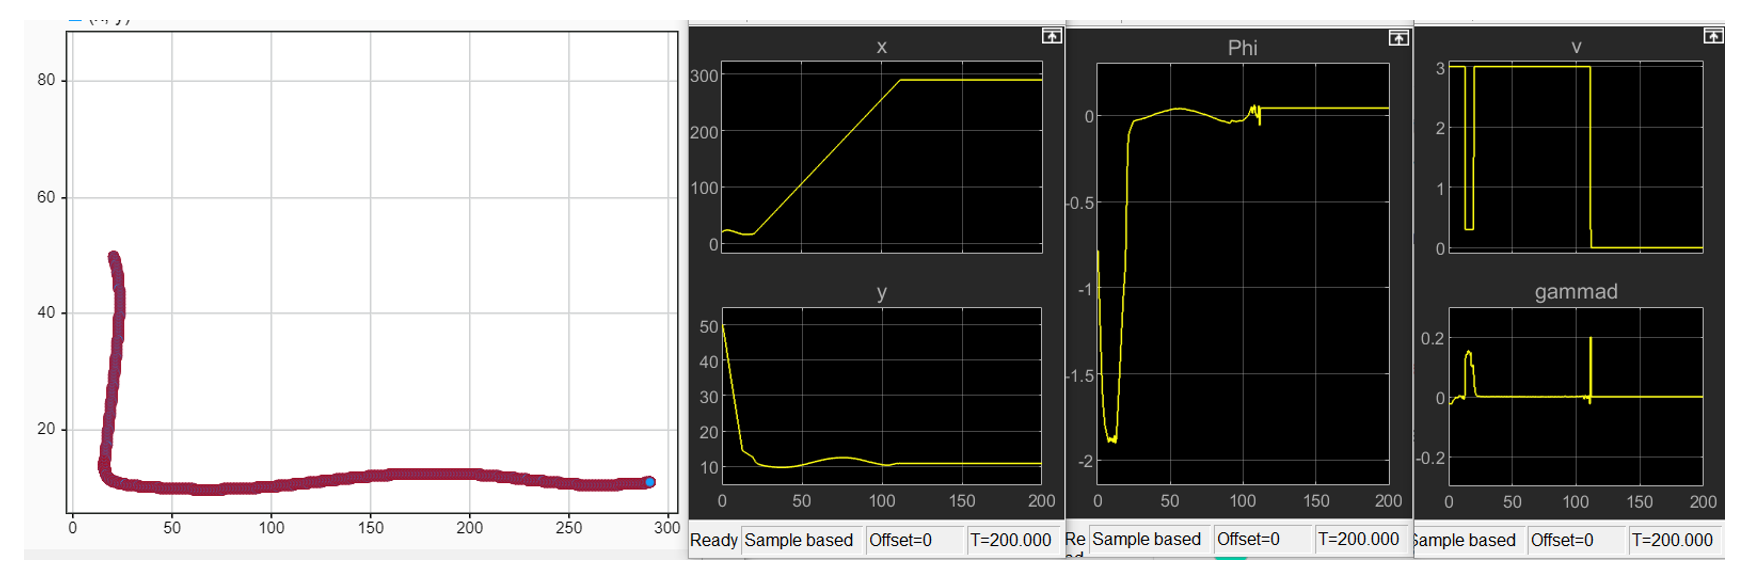

#### par.Pose0 = [290; 15; -pi]; % Desde SE a NW

Si en lugar de empezar en la pared izquierda se empieza en la pared derecha y se orienta el robot hacia la izquierda, el robot hace su recorrido siguiendo la pared del fondo primero y después la pared de arriba, que siguen estando a su derecha

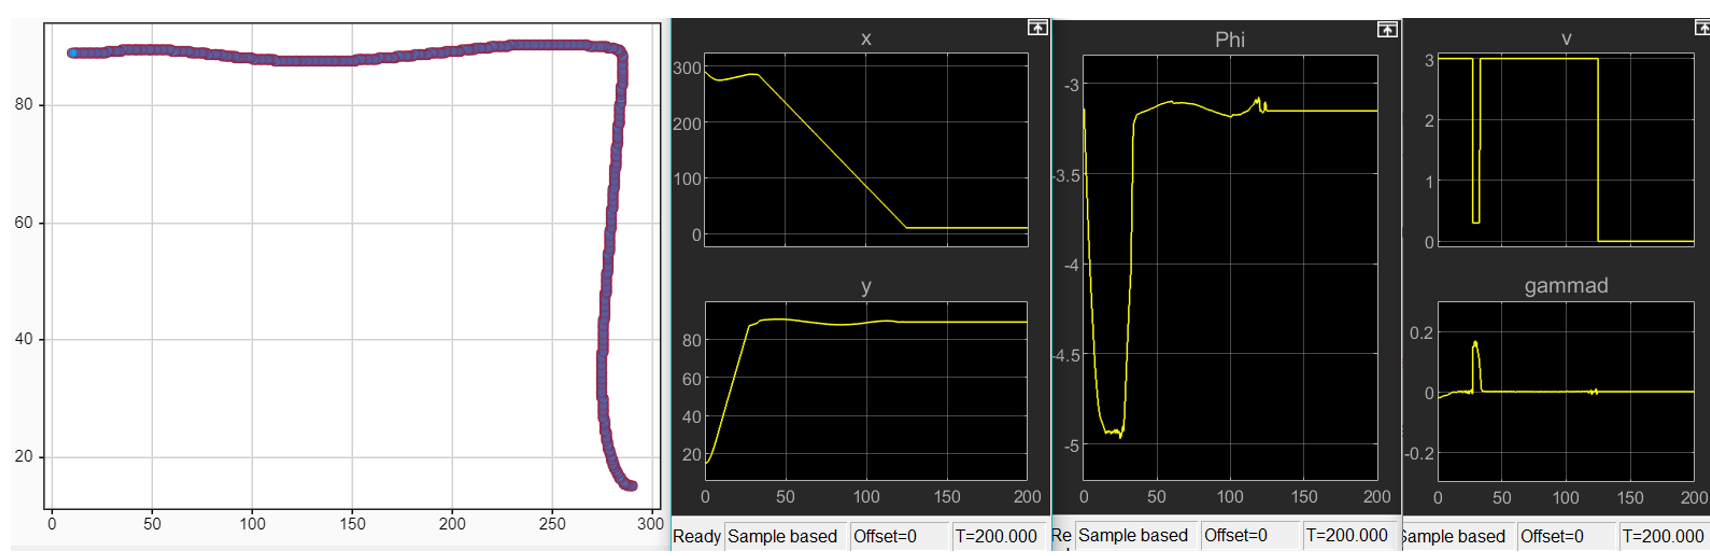